# Set Up

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.2 MB 7.7 MB/s 
     |████████████████████████████████| 4.2 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 50.1 MB/s 
     |████████████████████████████████| 6.6 MB 34.3 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!cp /content/drive/MyDrive/mumin-classifier/tg_data.py /content
!cp /content/drive/MyDrive/mumin-classifier/data_utils.py /content

# Training 

In [ ]:
def compute_metrics(eval_pred):
    """Computes accuracy, f1, precision, and recall from a 
    transformers.trainer_utils.EvalPrediction object.
    """
    from sklearn import metrics
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)

    accuracy = metrics.accuracy_score(y_true=labels, y_pred=preds)
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true=labels, y_pred=preds, average='macro')

    result = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

    return result

def model_init():
    """Returns an initialized model for use in a Hugging Face Trainer."""
    from transformers import RobertaConfig, RobertaForSequenceClassification

    configuration = RobertaConfig()
    model = RobertaForSequenceClassification(configuration).from_pretrained("roberta-base")

    return model

In [ ]:

import tg_data
import data_utils
import pandas as pd
import torch
import transformers
from transformers import RobertaTokenizer, Trainer, TrainingArguments
from transformers import BertTokenizer, RobertaForSequenceClassification
import sklearn
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score

train_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/train_en.csv")
val_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/val_en.csv")
test_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/test_en.csv")

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_data = tg_data.TGDataset(train_df, tokenizer)
val_data = tg_data.TGDataset(val_df, tokenizer)
test_data = tg_data.TGDataset(test_df, tokenizer)


model_path = 'out_roberta'
trainingargs = TrainingArguments(
    output_dir=model_path,
    do_train=True,
    do_eval=True,
    disable_tqdm=False,
    learning_rate=1e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    logging_first_step=True,
    #save_steps=1000,
    evaluation_strategy = "epoch"
    )

trainer = Trainer(
    args = trainingargs,
    tokenizer = tokenizer,
    train_dataset = train_data,
    eval_dataset = val_data,
    model_init = model_init,
    compute_metrics = compute_metrics
    )


print("STARTED TRAINING")
#trainer.train()
print("TRAINING DONE")

#trainer.save_model()
print("MODEL SAVED")    

ModuleNotFoundError: ignored

In [ ]:
predictions = trainer.predict(test_data)
preds = np.argmax(predictions.predictions, axis=-1)

test_scores = f1_score(test_data.label_list, preds, average=None)

print(f'\nMisinformation F1: {100 * test_scores[1]:.2f}%')
print(f'Factual F1: {100 * test_scores[0]:.2f}%')
print(f'macro-average F1: {100 * test_scores.mean():.4f}%\n')


report = sklearn.metrics.classification_report(y_pred=preds, y_true=predictions.label_ids)

print(report)

***** Running Prediction *****
  Num examples = 543
  Batch size = 8



Misinformation F1: 96.84%
Factual F1: 19.51%
macro-average F1: 58.1772%

              precision    recall  f1-score   support

           0       0.21      0.18      0.20        22
           1       0.97      0.97      0.97       521

    accuracy                           0.94       543
   macro avg       0.59      0.58      0.58       543
weighted avg       0.94      0.94      0.94       543



# Evaluation

In [ ]:
import pandas as pd 
train_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/train_en.csv")
val_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/val_en.csv")
test_df = pd.read_csv("/content/drive/MyDrive/mumin-classifier/data/test_en.csv")

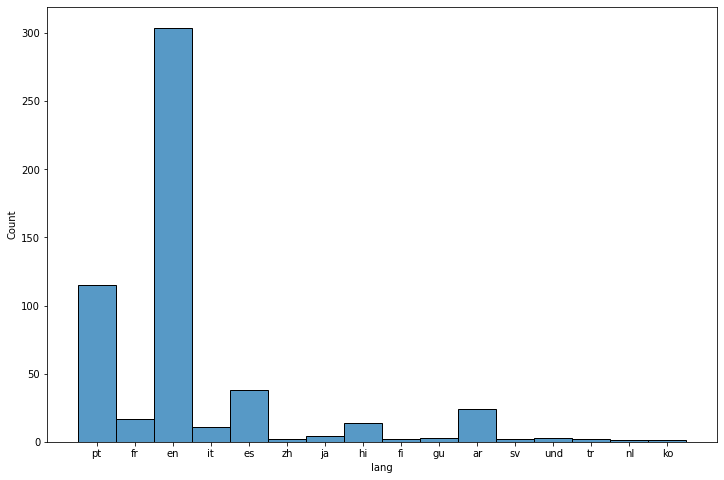

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.histplot(test_df.lang);

In [ ]:
langs = pd.concat([val_df, test_df])
langs = langs.query("lang=='en' | lang=='pt' | lang=='es'| lang=='fr'| lang=='ar'")

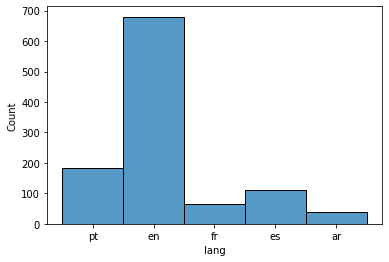

In [ ]:
sns.histplot(langs.lang);

In [ ]:
from sklearn.dummy import DummyClassifier
langs = pd.concat([val_df, test_df])
langs = langs.query("lang=='en' | lang=='pt' | lang=='es'| lang=='fr'| lang=='ar'")
languages = ['en','pt','es','fr','ar']
f1 = []
randomf1 = []
for lang in languages:
  print("\nLANG ", lang)
  lang_data = langs.query(f"lang=='{lang}'")
  test_data = tg_data.TGDataset(lang_data, tokenizer)
  predictions = trainer.predict(test_data)
  preds = np.argmax(predictions.predictions, axis=-1)

  test_scores = f1_score(test_data.label_list, preds, average=None)

  print(f'\nMisinformation F1: {100 * test_scores[1]:.2f}%')
  print(f'Factual F1: {100 * test_scores[0]:.2f}%')
  print(f'macro-average F1: {100 * test_scores.mean():.4f}%\n')
  f1.append(100 * test_scores.mean())

  model = DummyClassifier(strategy="most_frequent")

  lang_train_data = train_df.query(f"lang=='{lang}'")

  model.fit(lang_train_data.text, lang_train_data.label)

  test_preds = model.predict(lang_data.text)

  test_scores = f1_score(lang_data.label, test_preds , average=None)

  print(f'\nMisinformation F1: {100 * test_scores[1]:.2f}%')
  print(f'Factual F1: {100 * test_scores[0]:.2f}%')
  print(f'macro-average F1: {100 * test_scores.mean():.4f}%\n')
  randomf1.append(100 * test_scores.mean())



LANG  en


***** Running Prediction *****
  Num examples = 680
  Batch size = 8


***** Running Prediction *****
  Num examples = 182
  Batch size = 8



Misinformation F1: 93.59%
Factual F1: 16.49%
macro-average F1: 55.0408%


Misinformation F1: 98.28%
Factual F1: 0.00%
macro-average F1: 49.1399%


LANG  pt


***** Running Prediction *****
  Num examples = 111
  Batch size = 8



Misinformation F1: 96.59%
Factual F1: 0.00%
macro-average F1: 48.2955%


Misinformation F1: 99.72%
Factual F1: 0.00%
macro-average F1: 49.8623%


LANG  es


***** Running Prediction *****
  Num examples = 66
  Batch size = 8



Misinformation F1: 88.44%
Factual F1: 0.00%
macro-average F1: 44.2211%


Misinformation F1: 99.09%
Factual F1: 0.00%
macro-average F1: 49.5455%


LANG  fr


***** Running Prediction *****
  Num examples = 38
  Batch size = 8



Misinformation F1: 96.06%
Factual F1: 0.00%
macro-average F1: 48.0315%


Misinformation F1: 99.24%
Factual F1: 0.00%
macro-average F1: 49.6183%


LANG  ar

Misinformation F1: 92.96%
Factual F1: 0.00%
macro-average F1: 46.4789%


Misinformation F1: 98.67%
Factual F1: 0.00%
macro-average F1: 49.3333%



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:52

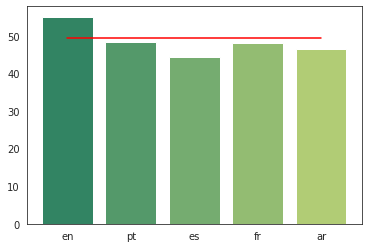

In [ ]:
sns.set_palette("summer")
sns.set_style("white")
sns.barplot(languages, f1)
sns.lineplot(languages, sum(randomf1)/len(randomf1), c="r")

In [ ]:
randomf1